# Fitting a transfer function with CurveFit and TransferFunctionModel
In this tutorial, we will use ``kontrol.curvefit.CurveFit`` to fit a measured transfer function.
As is mentioned in previous tutorial, ``kontrol.curvefit.CurveFit`` requires a few things, the independent variable data ``xdata``, the dependent variable ``ydata``, the model ``model``, the cost function ``cost``, and the optimizer.
They have the following signature:
```
xdata : array
ydata : array
model : func(x: array, *args, **kwargs) -> array
cost : func(args: array, model: func, xdata: array, ydata: array, model_kwargs: dict) -> float
optimizer : func(cost: func, **kwargs) -> scipy.optimize.OptimzeResult
```
To save you a lot of troubles, ``kontrol`` library provides various models classes ``kontrol.curvefit.model``, cost functions (error functions). And optimizers are readily available in ``scipy.optimize``. So we typically just need to prepare ``xdata`` and ``ydata``.
Of course, knowing what model, error function, and optimizer to use is crucial in a curve fitting task. 

This time, we will use the model ``kontrol.curvefit.model.TransferFunctionModel`` as our model this time.
This model can be defined by the number of zeros ``nzero`` and ``npole``. The parameters are simply concatenated coefficients of numerator and denominator arranging from high to low order.

Here, let's consider the transfer function

\begin{equation}
    H(s) = \frac{s^2 + 3s + 2}{s^3 + 12s^2 + 47s + 60}
\end{equation}

So the parameters we would like to recover are the coefficients ``[1, 3, 2, 1, 12, 47, 60]``.

For the sake of demonstration, let's assume that we know there are 2 zeros and 3 poles as this is required to define a model.

We will use ``kontrol.curvefit.error_func.tf_error`` as the error function and it is defined as
\begin{equation}
E_\mathrm{tf\_error}\left(H_1(f), H_2(f); w(f), \epsilon\right) = \frac{1}{N}\sum_{i=0}^{N} \log_{10}(\lvert(H_1(f_i) - H_2(f_i)+\epsilon)w(f_i)\rvert)\,,
\end{equation}
where $H_1(f)$ and $H_2(f)$ are the frequency responses values (complex array) of the measured system and the model, $\epsilon$ is a small number to prevent $\log_{10}$ from exploding, $w(f)$ is a weighting function, and $N$ is the total number of data points.

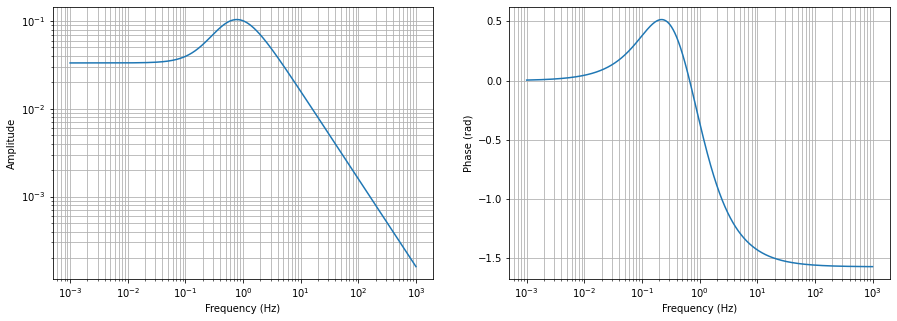

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt

f = np.logspace(-3, 3, 100000)
s = 1j*2*np.pi*f
tf = (s**2 + 3*s + 2) / (s**3 + 12*s**2 + 47*s + 60)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf))
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf))
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

Now, let's everything that ``kontrol.curvefit.CurveFit`` needs, namely ``xdata``, ``ydata``, ``model``, ``cost``, and ``optimizer``.

In [2]:
import kontrol.curvefit
import scipy.optimize


xdata = f
ydata = tf
model = kontrol.curvefit.model.TransferFunctionModel(nzero=2, npole=3, log_args=False)
error_func = kontrol.curvefit.error_func.tf_error
cost = kontrol.curvefit.Cost(error_func=error_func)
optimizer = scipy.optimize.minimize

Since we're using ``scipy.optimize.minimize``, it requires an initial guess. Let's start with all ones.

In [3]:
x0 = np.ones(7)  # There are 7 coefficients, 3 for numerator and 4 for denominator
optimizer_kwargs = {"x0": x0}

Now let's use ``kontrol.curvefit.CurveFit`` to fit the data.

In [4]:
a = kontrol.curvefit.CurveFit()
a.xdata = xdata
a.ydata = ydata
a.model = model
a.cost = cost
a.optimizer = optimizer
a.optimizer_kwargs = optimizer_kwargs
res = a.fit()

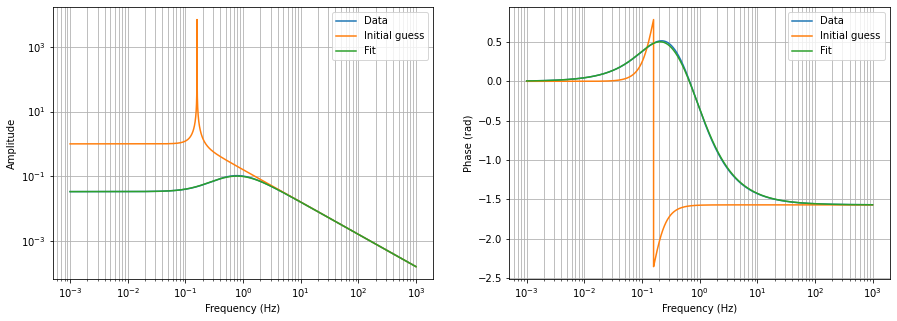

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf), label="Data")
plt.loglog(f, abs(a.model(f, x0)), label="Initial guess")
plt.loglog(f, abs(a.yfit), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf), label="Data")
plt.semilogx(f, np.angle(a.model(f, x0)), label="Initial guess")
plt.semilogx(f, np.angle(a.yfit), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [6]:
res.x/res.x[0]

array([ 1.        ,  1.78627675,  0.84976028,  1.00034299, 11.024541  ,
       35.31604716, 25.492815  ])

Looks great, right? But, this is not typically that easy. This above case was easy because I have set the frequency array to logspace whereas we typically get a linspace array from fourier transform of linearly spaced time domain data!

Now let's see what happens if we switch back to linspace.

In [7]:
f = np.linspace(0.001, 1000, 100000)
s = 1j*2*np.pi*f
tf = (s**2 + 3*s + 2) / (s**3 + 12*s**2 + 47*s + 60)

xdata = f
ydata = tf
model = kontrol.curvefit.model.TransferFunctionModel(nzero=2, npole=3, log_args=False)
error_func = kontrol.curvefit.error_func.tf_error
cost = kontrol.curvefit.Cost(error_func=error_func)
optimizer = scipy.optimize.minimize

x0 = np.ones(7)  # There are 7 coefficients, 3 for numerator and 4 for denominator
optimizer_kwargs = {"x0": x0}

a = kontrol.curvefit.CurveFit()
a.xdata = xdata
a.ydata = ydata
a.model = model
a.cost = cost
a.optimizer = optimizer
a.optimizer_kwargs = optimizer_kwargs
res = a.fit()

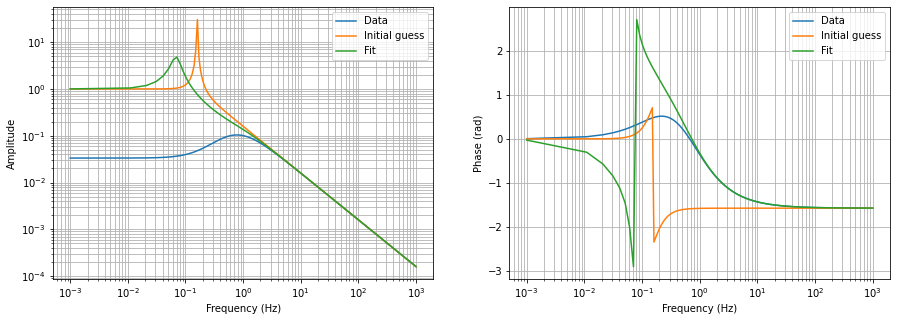

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf), label="Data")
plt.loglog(f, abs(a.model(f, x0)), label="Initial guess")
plt.loglog(f, abs(a.yfit), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf), label="Data")
plt.semilogx(f, np.angle(a.model(f, x0)), label="Initial guess")
plt.semilogx(f, np.angle(a.yfit), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

Not great! Terrible!

It turns out that there're a few tricks that can be used fit linspace transfer function data.

1. Weighing function (1/f).
2. Parameter scaling (log).
3. Use other optimizers (differential evolution, Nelder-Mead, Powell, etc).
4. Use better initial guess.
5. Tighter acceptable tolerance for convergence during minimization (e.g. ``ftol``, ``xtol``. Different optimizers use different convention)

We will use all of them!

In [9]:
a = kontrol.curvefit.CurveFit()
a.xdata = f
a.ydata = tf
# Use 1/f weighting
weight = 1/f
error_func_kwargs = {"weight": weight}
a.cost = kontrol.curvefit.Cost(error_func=error_func, error_func_kwargs=error_func_kwargs)

# Use log scaling. Models have an argument for enabling that.
a.model = kontrol.curvefit.model.TransferFunctionModel(nzero=2, npole=3, log_args=True)

# Use better initial guess and Nelder-Mead optimizer.
np.random.seed(123)
true_args = np.array([1, 3, 2, 1, 12, 47, 60])  # These are the true parameters
noise = np.random.normal(loc=0, scale=true_args/10, size=7)
x0 = true_args + noise  # Now the initial guess is assumed to be some deviation from the true values.
# x0 = np.ones(7)
a.optimizer_kwargs = {"x0": np.log10(x0), "method": "powell", "options": {"xtol": 1e-12, 'ftol': 1e-12}}  # Note the inital guess is log.
a.optimizer = scipy.optimize.minimize
res = a.fit()

In [10]:
10**a.optimize_result.x

array([ 2.25124892,  3.66597884,  1.51466572,  2.25137845, 23.92566764,
       77.41975222, 45.43996825])

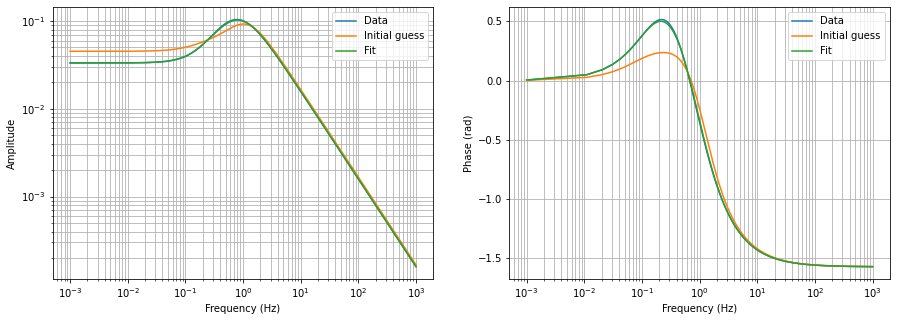

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf), label="Data")
plt.loglog(f, abs(a.model(f, np.log10(x0))), label="Initial guess")
plt.loglog(f, abs(a.yfit), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf), label="Data")
plt.semilogx(f, np.angle(a.model(f, np.log10(x0))), label="Initial guess")
plt.semilogx(f, np.angle(a.yfit), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [12]:
fitted_args = 10**a.optimized_args
fitted_args /= fitted_args[0]
fitted_args

array([ 1.        ,  1.62842003,  0.6728113 ,  1.00005754, 10.62773089,
       34.38968995, 20.18433765])

In [13]:
print("True arguments: ", true_args)
print("Initial arguments: ", x0/x0[0])
print("Arguments optained from fitting: ", fitted_args)

True arguments:  [ 1  3  2  1 12 47 60]
Initial arguments:  [ 1.          3.70099497  2.30705685  0.95281056 12.68253445 61.43087558
 50.97379581]
Arguments optained from fitting:  [ 1.          1.62842003  0.6728113   1.00005754 10.62773089 34.38968995
 20.18433765]


In [14]:
print("True transfer function")
s = control.tf("s")
tf = (s**2 + 3*s + 2) / (s**3 + 12*s**2 + 47*s + 60)
tf

True transfer function


TransferFunction(array([1, 3, 2]), array([ 1, 12, 47, 60]))

In [15]:
print("Fitted transfer function")
a.model.args = a.optimized_args
a.model.tf.minreal()

Fitted transfer function


TransferFunction(array([0.99994246, 1.62832634, 0.67277259]), array([ 1.        , 10.62711942, 34.38771132, 20.18317633]))

The fit looks good.
But, apparently it has found a set of different parameters.
See further tutorials for alternative ways of fitting the same transfer function.

Nevertherless, we demonstrated the use of ``kontrol.curvefit.CurveFit`` for transfer function fitting.